<font size="+12"><center>
    MVPA analysis: SVM
</font></center>

Author:
Egor Ananyev

# Preparation

## Loading packages

In [2]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import os

In [3]:
mne.set_log_level('warning')  # less verbose output

## Setting parameters

In [4]:
interactive = False  # Whether to render interactive figures such as channel plots
# ...should be set to True on first pass

debug = False

cur_subj = 1
numof_runs = 7

## Loading evoked data

In [5]:
# data_path = os.path.expanduser("C:\\Users\\egora\\Downloads\\meg\\")
data_path = os.path.expanduser('E:\\meg\\')

cur_subj_str = str(cur_subj).zfill(2)

epochs_list = []

for cur_run in range(numof_runs):
    cur_run_str = str(cur_run+1).zfill(2)
    fname = os.path.join(data_path,
                             'derivatives\\meg_derivatives\\sub-' + cur_subj_str + '\\ses-meg\\meg\\sub-' + \
                             cur_subj_str + '_ses-meg_experimental_run-' + cur_run_str + '_proc-sss_epo.fif')
    print(fname)
    epochs_run = mne.read_epochs(fname)
    # example append: https://www.programcreek.com/python/example/92634/mne.Epochs
    epochs_list.append(epochs_run)

E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-01_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-02_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-03_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-04_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-05_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-06_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-07_proc-sss_epo.fif


In [6]:
for i in range(len(epochs_list)):
    print(epochs_list[i].info['dev_head_t'])

<Transform  |  MEG device->head>
[[ 0.99762779 -0.05008168 -0.04722238  0.00244267]
 [ 0.04592873  0.99529868 -0.08526584 -0.02767636]
 [ 0.05127066  0.08289474  0.99523813  0.04869793]
 [ 0.          0.          0.          1.        ]]
<Transform  |  MEG device->head>
[[ 0.99810284 -0.04287035 -0.0441924   0.0025069 ]
 [ 0.04004742  0.99721628 -0.06289711 -0.02748199]
 [ 0.0467658   0.06100798  0.99704117  0.05019899]
 [ 0.          0.          0.          1.        ]]
<Transform  |  MEG device->head>
[[ 0.99834144 -0.03760644 -0.04358925  0.00234504]
 [ 0.03564318  0.99835205 -0.04497451 -0.02764969]
 [ 0.04520874  0.04334626  0.99803674  0.05217394]
 [ 0.          0.          0.          1.        ]]
<Transform  |  MEG device->head>
[[ 0.99837339 -0.03827842 -0.04224655  0.00280504]
 [ 0.03683717  0.99872935 -0.03438213 -0.02761227]
 [ 0.04350897  0.03276998  0.99851513  0.05331092]
 [ 0.          0.          0.          1.        ]]
<Transform  |  MEG device->head>
[[ 0.99817234 -

In [18]:
epochs_list[0].info

<Info | 28 non-empty fields
    acq_pars : str | 25272 items
    bads : list | 0 items
    ch_names : list | EOG001, EOG002, MEG0111, MEG0112, MEG0113, MEG0121, ...
    chs : list | 308 items (EOG: 2, MAG: 102, GRAD: 204)
    comps : list | 0 items
    custom_ref_applied : bool | False
    description : str | 34 items
    dev_head_t : Transform | 3 items
    dig : Digitization | 149 items (3 Cardinal, 4 HPI, 142 Extra)
    events : list | 2 items
    experimenter : str | 17 items
    file_id : dict | 4 items
    gantry_angle : float | 68.0
    highpass : float | 0.10000000149011612 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    hpi_subsystem : dict | 2 items
    line_freq : float | 50.0
    lowpass : float | 80.0 Hz
    meas_date : tuple | 2020-02-05 07:22:14 GMT
    meas_id : dict | 4 items
    nchan : int | 308
    proc_history : list | 2 items
    proj_id : ndarray | 1 items
    proj_name : str | 24 items
    projs : list | 0 items
    sfreq : float | 300.0 Hz

In [13]:
# epochs = mne.epochs.concatenate_epochs(epochs_list)  # this won't work until the epochs have the same head position coordinates

ValueError: epochs[0]['info']['dev_head_t'] must match. The epochs probably come from different runs, and are therefore associated with different head positions. Manually change info['dev_head_t'] to avoid this message but beware that this means the MEG sensors will not be properly spatially aligned. See mne.preprocessing.maxwell_filter to realign the runs to a common head position.

The path to store MVPA-related data and visualization.

In [19]:
mvpa_path = os.path.join(data_path, 'derivatives\\meg_derivatives\\sub-' + cur_subj_str + '\\ses-meg\\meg-mvpa\\')
mvpa_fname = os.path.join(mvpa_path, 'sub-' + cur_subj_str + '_run-' + cur_run_str)

## Examining raw data

In [20]:
%matplotlib qt
if interactive:
    raw.plot()

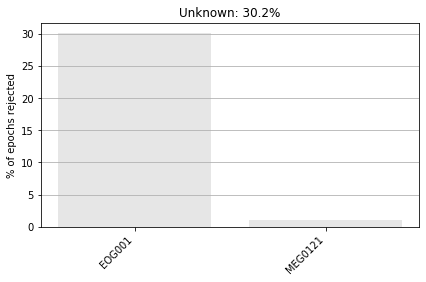

In [24]:
%matplotlib inline
epochs_list[0].plot_drop_log();

# Support Vector Machines

In [25]:
from sklearn import svm

## Logic of SVM-based classification

In [26]:
## In principle (from https://scikit-learn.org/stable/modules/svm.html):
X = [[0, 0], [1, 1], [2, 2]]  # channel measurements [n_features] on all but one trial [n_samples] at time t
y = [0, 1, 1]                 # stimulus orientation with length [n_samples]
clf = svm.LinearSVC()         # linear Support Vector Classification
clf.fit(X, y)                 # model fitting
clf.predict([[3, 3]])         # model testing on the remaining trial at time t

array([1])

In [27]:
np.shape(X)  # array of size [n_samples, n_features]

(3, 2)

## Assuming independent _t_

## Setting up routine for time _t_

In [29]:
epochs = epochs_list[0]  # TEMP
epochs

<EpochsFIF  |   134 events (all good), -0.3 - 0.6 sec, baseline [-0.2, 0], ~90.8 MB, data loaded,
 'left/dur1/cont017': 5
 'left/dur1/cont033': 5
 'left/dur1/cont050': 2
 'left/dur1/cont100': 6
 'left/dur2/cont017': 3
 'left/dur2/cont033': 2
 'left/dur2/cont050': 4
 'left/dur2/cont100': 5
 'left/dur3/cont017': 4
 'left/dur3/cont033': 4
 'left/dur3/cont050': 5
 'left/dur3/cont100': 4
 'left/dur4/cont017': 4
 'left/dur4/cont033': 5
 'left/dur4/cont050': 5
 'left/dur4/cont100': 3
 'right/dur1/cont017': 4
 'right/dur1/cont033': 4
 'right/dur1/cont050': 3
 'right/dur1/cont100': 5
 'right/dur2/cont017': 5
 'right/dur2/cont033': 5
 'right/dur2/cont050': 4
 'right/dur2/cont100': 4
 'right/dur3/cont017': 3
 'right/dur3/cont033': 6
 'right/dur3/cont050': 6
 'right/dur3/cont100': 5
 'right/dur4/cont017': 3
 'right/dur4/cont033': 3
 'right/dur4/cont050': 6
 'right/dur4/cont100': 2>

In [192]:
all_durs = [1, 2, 3, 4]
all_conts = [17, 33, 50, 100]

In [195]:
cur_cond_str = 'dur' + str(all_durs[0]) + '/' + 'cont' + str(all_conts[0]).zfill(3)
print(cur_cond_str)
epochs_subset = epochs[cur_cond_str]
print(epochs_subset)

dur1/cont017
<EpochsFIF  |   9 events (all good), -0.3 - 0.6 sec, baseline [-0.2, 0], ~11.2 MB, data loaded,
 'left/dur1/cont017': 5
 'right/dur1/cont017': 4>


In [39]:
epochs_subset.pick_types(meg=True)

<EpochsFIF  |   11 events (all good), -0.3 - 0.6 sec, baseline [-0.2, 0], ~12.5 MB, data loaded,
 'left/dur1/cont100': 6
 'right/dur1/cont100': 5>

In [80]:
numof_epochs = len(epochs_subset)
print(numof_epochs)

11


In [187]:
epochs_df = epochs_subset.to_data_frame()
print(epochs_df.iloc[:,0:4].head());

channel                           MEG0111    MEG0112    MEG0113     MEG0121
condition          epoch time                                              
right/dur1/cont100 0     -300  201.295778  50.719486 -21.640064   80.596221
                         -297  141.378977  67.954471 -24.376182   60.121343
                         -293  193.228826  73.471652   1.081352   62.122191
                         -290  268.493123  71.581542 -17.437494  124.938844
                         -287  338.802847  62.683617 -78.063713  257.800539


In [188]:
# epochs_df.reset_index(inplace=True);

In [189]:
# epochs_df.reset_index(inplace=True)
# df_info = epochs_df.loc[:, ('condition', 'epoch', 'time')]
# df_info['stim_ori'] = 'right'
# df_info.loc[df_info['condition'].str.contains('left'), 'stim_ori'] = 'left'
# df_info['dur_frames'] = 1
# df_info.loc[df_info['condition'].str.contains('dur2'), 'dur_frames'] = 2
# df_info.loc[df_info['condition'].str.contains('dur3'), 'dur_frames'] = 3
# df_info.loc[df_info['condition'].str.contains('dur4'), 'dur_frames'] = 4
# df_info['cont'] = 1
# df_info.loc[df_info['condition'].str.contains('cont017'), 'cont'] = .17
# df_info.loc[df_info['condition'].str.contains('cont033'), 'cont'] = .33
# df_info.loc[df_info['condition'].str.contains('cont050'), 'cont'] = .50

In [190]:
# df_info.head()

In [191]:
# df_info.tail()

In [59]:
print(epochs_df.columns.values[0:21])

['MEG0111' 'MEG0112' 'MEG0113' 'MEG0121' 'MEG0122' 'MEG0123' 'MEG0131'
 'MEG0132' 'MEG0133' 'MEG0141' 'MEG0142' 'MEG0143' 'MEG0211' 'MEG0212'
 'MEG0213' 'MEG0221' 'MEG0222' 'MEG0223' 'MEG0231' 'MEG0232' 'MEG0233']


In [118]:
t = 100

In [119]:
X_right = epochs_df.loc[('right/dur1/cont100', slice(None), t), :].values
print(X_right)
print(np.shape(X_right))

[[  36.13831441   58.3120612    22.47588984 ...  -50.40907533
   -43.6406868   -24.33343703]
 [  27.83398239  -55.85968167  -45.89182437 ...    1.92184782
   -16.79187122  -41.24115485]
 [-282.58234335   80.5276084    51.54396065 ... -157.51119482
     8.31654497  -24.7770052 ]
 [-319.16347449  -16.3122307    58.11697513 ... -241.85410438
    22.74297479    5.5450833 ]
 [  59.53197322  143.11320492    3.46058972 ... -119.55543861
    95.00892231  -65.54501875]]
(5, 306)


In [120]:
X_left = epochs_df.loc[('left/dur1/cont100', slice(None), t), :].values
print(X_left)
print(np.shape(X_left))

[[-162.93342469  123.66760284   91.50989747 ...  -45.4647743
    15.65298343  -10.27779564]
 [ 355.9375887   -38.17670591   51.43670372 ...  -97.79519557
    27.5736111    -3.4157169 ]
 [ 135.12884303   41.94296762  -44.91928053 ...   67.85846369
   114.434574    -52.49250081]
 [-142.40856598   39.41720673  135.82746359 ... -277.37629044
     0.93165612  -20.1188201 ]
 [ 246.18057004  -56.46818395  -72.82657311 ... -124.86732719
   -43.67751876   33.95147267]
 [-495.68728018   66.94981713  -60.18928836 ... -146.76822769
    41.1417766     4.30323949]]
(6, 306)


In [101]:
X = np.concatenate((X_right, X_left))
np.shape(X)

(11, 306)

In [107]:
y = np.concatenate((np.repeat(1, len(X_right)), np.repeat(0, len(X_left))))
print(y)

[1 1 1 1 1 0 0 0 0 0 0]


In [126]:
clf = svm.LinearSVC()         # linear Support Vector Classification
clf.fit(X, y)                 # model fitting
clf.predict([X[4, :]])        # model testing on the remaining trial at time t

array([1])

In [128]:
cur_test_epoch = 1 
np.arange(numof_epochs)!=cur_test_epoch

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [156]:
preds = []
for cur_test_epoch in range(numof_epochs):
    test_epoch = [X[cur_test_epoch, :]]
    test_class = y[cur_test_epoch]
    train_epochs = X[np.arange(numof_epochs)!=cur_test_epoch, :]
    train_classes = y[np.arange(numof_epochs)!=cur_test_epoch]
    clf = svm.LinearSVC()         # linear Support Vector Classification
    clf.fit(train_epochs, train_classes)                 # model fitting
    prediction = clf.predict(test_epoch).item(0)        # model testing on the remaining trial at time t
    preds.append(prediction)
#     print('prediction = ' + str(prediction))
#     print('actual value = ' + str(test_class))
acc = sum(y == np.array(preds)) / numof_epochs
print(acc)

0.5454545454545454


In [151]:
preds

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]

In [ ]:
np

## Applying the routine to all _t_

# P.S.

In [62]:
%matplotlib
%matplotlib qt

Using matplotlib backend: Qt5Agg


In [63]:
interactive = True